In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras.applications.nasnet import NASNetMobile, preprocess_input   
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.applications.nasnet import NASNetMobile, preprocess_input          
       

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"C:\Users\shruthi sree\Downloads\Face-Mask-Detection-master\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [3]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

C:\Users\shruthi sree\Anaconda new\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [5]:
baseModel = NASNetMobile(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()
for layer in baseModel.layers:
    layer.trainable = False

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           stem_bn1[0][0]                   
______________________________________________________________________________________________

In [6]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
95/95 [==============================] - 201s 2s/step - loss: 0.5459 - accuracy: 0.7591 - val_loss: 0.1828 - val_accuracy: 0.9700
Epoch 2/20
95/95 [==============================] - 171s 2s/step - loss: 0.1969 - accuracy: 0.9475 - val_loss: 0.1106 - val_accuracy: 0.9778
Epoch 3/20
95/95 [==============================] - 187s 2s/step - loss: 0.1339 - accuracy: 0.9575 - val_loss: 0.0824 - val_accuracy: 0.9804
Epoch 4/20
95/95 [==============================] - 175s 2s/step - loss: 0.0918 - accuracy: 0.9755 - val_loss: 0.0745 - val_accuracy: 0.9817
Epoch 5/20
95/95 [==============================] - 185s 2s/step - loss: 0.0970 - accuracy: 0.9681 - val_loss: 0.0589 - val_accuracy: 0.9857
Epoch 6/20
95/95 [==============================] - 192s 2s/step - loss: 0.0730 - accuracy: 0.9775 - val_loss: 0.0549 - val_accuracy: 0.9857
Epoch 7/20
95/95 [==============================] - 185s 2s/step - loss: 0.0707 - accuracy: 0.9757 - val

In [7]:
print("[INFO] saving mask detector model...")
model.save("mask_detector_nasnet.model", save_format="h5")

[INFO] saving mask detector model...


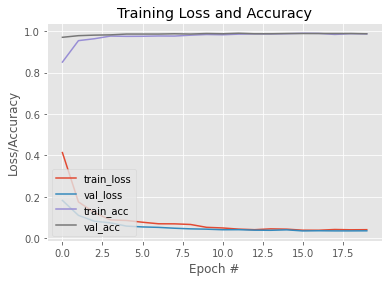

In [8]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

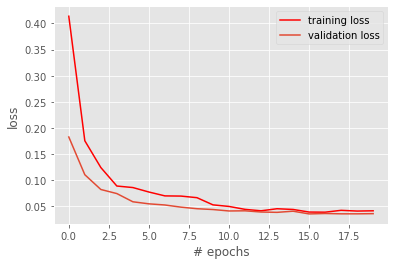

In [9]:
from matplotlib import pyplot as plt

plt.plot(H.history['loss'],'r',label='training loss')
plt.plot(H.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

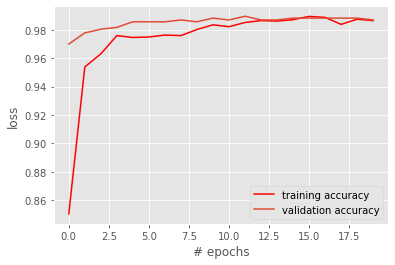

In [10]:
plt.plot(H.history['accuracy'],'r',label='training accuracy')
plt.plot(H.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()